Convolutional Neural Network - Speaker Dependent

In [1]:
# import library
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random as rn

2022-02-01 15:11:51.667461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-01 15:11:51.667772: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
cd ..

/home/fafa/Documents/speech_emotion_recognition


In [3]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

In [4]:
# load feature data
data_path = 'data/speech/' # choose song or speech
X = np.load(data_path + 'x.npy')
y = np.load(data_path + 'y.npy')

# reshape x untuk cnn
X = X.reshape(X.shape[0], X.shape[1], 1)

In [5]:
# split into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=10,
                                             restore_best_weights=True)

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)

In [6]:
# function to define model
def model_cnn():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(axis=-1,
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(tf.keras.layers.Conv1D(256, 128, 1, padding='same'))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(8, activation='softmax'))

    # compile model: set loss, optimizer, metric
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [7]:
# create the model
model = model_cnn()
print(model.summary())

2022-02-01 15:12:06.202993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-01 15:12:06.203112: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-01 15:12:06.203190: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-02-01 15:12:06.204006: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 386, 1)           4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 386, 256)          33024     
                                                                 
 activation (Activation)     (None, 386, 256)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 193, 256)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 49408)             0         
                                                                 
 dropout (Dropout)           (None, 49408)             0

In [8]:
# plot model
tf.keras.utils.plot_model(model,'cnn_model_sd_speech.pdf',show_shapes=True)

In [9]:
# train the model
hist = model.fit(x_train, 
                 y_train, 
                 epochs=100, 
                 shuffle=True,
                 #callbacks=earlystop,
                 validation_split=0.1,
                 batch_size=16)

Epoch 1/100
73/73 [==============================] - 6s 61ms/step - loss: 2.0458 - accuracy: 0.2058 - val_loss: 2.0458 - val_accuracy: 0.1923
Epoch 2/100
73/73 [==============================] - 4s 49ms/step - loss: 1.8860 - accuracy: 0.2762 - val_loss: 2.1614 - val_accuracy: 0.2462
Epoch 3/100
73/73 [==============================] - 3s 48ms/step - loss: 1.8677 - accuracy: 0.2770 - val_loss: 1.8223 - val_accuracy: 0.2462
Epoch 4/100
73/73 [==============================] - 4s 50ms/step - loss: 1.7801 - accuracy: 0.3285 - val_loss: 1.7987 - val_accuracy: 0.3462
Epoch 5/100
73/73 [==============================] - 4s 54ms/step - loss: 1.7287 - accuracy: 0.3413 - val_loss: 1.7527 - val_accuracy: 0.3308
Epoch 6/100
73/73 [==============================] - 4s 51ms/step - loss: 1.7203 - accuracy: 0.3559 - val_loss: 1.7591 - val_accuracy: 0.3154
Epoch 7/100
73/73 [==============================] - 4s 58ms/step - loss: 1.6749 - accuracy: 0.3559 - val_loss: 1.6248 - val_accuracy: 0.4308
Epoch 

In [10]:
# evaluate the model on test partition
evaluate = model.evaluate(x_test, y_test, batch_size=16)
print("Loss={:.6f}, Accuracy={:.6f}".format(evaluate[0],evaluate[1]))

9/9 [==============================] - 1s 13ms/step - loss: 0.7816 - accuracy: 0.7361
Loss=0.781646, Accuracy=0.736111


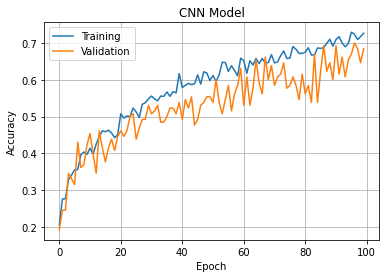

In [11]:
# plot accuracy
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.grid()
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model')
plt.savefig('cnn_accuracy_sd_speech.svg')

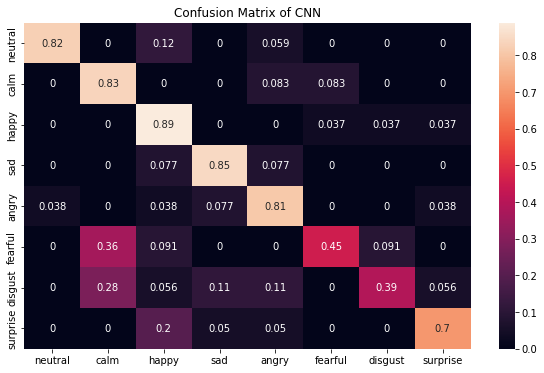

In [12]:
# make prediction for confusion_matrix
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
predict = model.predict(x_test, batch_size=16)
emotions=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprise']

# predicted emotions from the test set
y_pred = np.argmax(predict, 1)
predicted_emo = []
for i in range(0,y_test.shape[0]):
    emo = emotions[y_pred[i]]
    predicted_emo.append(emo)

# get actual emotion
actual_emo = []
y_true = y_test
for i in range(0,y_test.shape[0]):
    emo = emotions[y_true[i]]
    actual_emo.append(emo)

# generate the confusion matrix
cm = confusion_matrix(actual_emo, predicted_emo)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprise']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprise']
cm_df = pd.DataFrame(cm, index, columns)
plt.figure(figsize=(10, 6))
plt.title('Confusion Matrix of CNN')
sns.heatmap(cm_df, annot=True)
plt.savefig('cnn_cm_sd_speech.svg')

In [13]:
# print unweighted average recall
print("UAR: ", cm.trace()/cm.shape[0])

UAR:  0.7178790164084281
